<a href="https://colab.research.google.com/github/yingzibu/ODE/blob/main/code/neural_ODE_first_order_PO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install torchdiffeq --quiet

In [2]:
import os
import argparse
import time
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint_adjoint as odeint
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (3.5, 3)

In [108]:
# constant
method_ode = 'dopri5'
data_size = 1000
batch_time = 10
batch_size = 20
niters = 2000
test_freq = 5
viz = True
gpu_num = 0
adjoint = True
fig_path = 'png'
device = torch.device('cuda:'+str(gpu_num) if torch.cuda.is_available() else 'cpu')

\begin{equation*}
    \frac{d}{dt} \begin{bmatrix}
        A_a \\
        A
    \end{bmatrix} = \begin{bmatrix}
        -K_a & 0 \\
        K_a & -K
    \end{bmatrix}
    \begin{bmatrix}
        A_a \\
        A
    \end{bmatrix}
\end{equation*}

Then let  
    \begin{equation}
    M = \begin{bmatrix}
        -K_a & 0 \\
        K_a & -K
    \end{bmatrix}
    \end{equation}

In [19]:
# first order PO related constants
Dose = 2.0 # initial dose for PO
ka = 0.5
k = 0.2
MAX_T = 25

true_M = torch.tensor([[-ka, 0.], [ka, -k]]).to(device)
true_y0 = torch.tensor([[Dose, 0.]]).to(device) # initial conditions for Aa and A
t = torch.linspace(0., MAX_T, data_size).to(device)

For obtaining true_y which is $[A_a, A] \in \mathbb{R}^{1\times 2}$ a row vector, we have the ODE defined above, thus
$y = \text{ODESolver}(\text{ode_func}, y_0, t)$
We already know that by PK definition, the ode_func is defined as $dy/dt = yM^\top$, we would like to see whether NN could approximate the ode_func.

In [68]:
class ODEFunc(nn.Module):
    """
    Aim: use NN to approximate ode_func.
    Input dim should be the same as output dim,
    since dy/dt has the same dim of y

    param dim: int, input dimension
    return
        dy/dt, which is ode_func value at y
    """
    def __init__(self, dim=2):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 50),
            nn.Tanh(),
            nn.Linear(50, dim)
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
    def forward(self, t, y):
        return self.net(y)


class Lambda(nn.Module):
    def forward(self, t, y): # need transpose M, since y is a row vector
        return torch.mm(y, true_M.T)

with torch.no_grad():
    true_y = odeint(Lambda(),true_y0, t, method=method_ode)

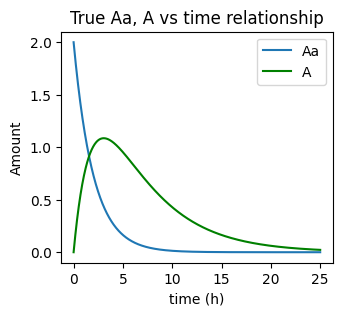

In [109]:
fig = plt.figure()
plt.plot(t.cpu().numpy(), true_y.cpu().numpy()[:,0,0],
         t.cpu().numpy(), true_y.cpu().numpy()[:,0,1], 'g-')

plt.legend(['Aa', 'A'])
plt.xlabel('time (h)')
plt.ylabel('Amount')
plt.title('True Aa, A vs time relationship')
plt.show()
plt.close()

In [79]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size-batch_time,
                                                    dtype=np.int64),
                         batch_size, replace=False))
    batch_y0 = true_y[s]
    batch_t = t[:batch_time]
    batch_y = torch.stack([true_y[s+i] for i in range(batch_time)], dim=0)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

def makedirs(dirname):
    if not os.path.exists(dirname): os.makedirs(dirname)

Epoch 0005 | Total Loss 0.330
Epoch 0010 | Total Loss 0.131
Epoch 0015 | Total Loss 0.099
Epoch 0020 | Total Loss 0.083
Epoch 0025 | Total Loss 0.026
Epoch 0030 | Total Loss 0.034
Epoch 0035 | Total Loss 0.023
Epoch 0040 | Total Loss 0.014
Epoch 0045 | Total Loss 0.017
Epoch 0050 | Total Loss 0.009


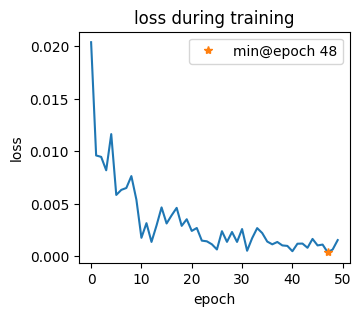

Epoch 0055 | Total Loss 0.015
Epoch 0060 | Total Loss 0.014
Epoch 0065 | Total Loss 0.016
Epoch 0070 | Total Loss 0.012
Epoch 0075 | Total Loss 0.011
Epoch 0080 | Total Loss 0.012
Epoch 0085 | Total Loss 0.011
Epoch 0090 | Total Loss 0.006
Epoch 0095 | Total Loss 0.006
Epoch 0100 | Total Loss 0.017


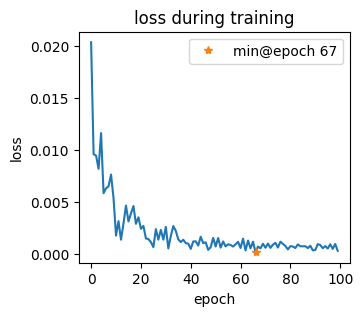

Epoch 0105 | Total Loss 0.011
Epoch 0110 | Total Loss 0.018
Epoch 0115 | Total Loss 0.008
Epoch 0120 | Total Loss 0.006
Epoch 0125 | Total Loss 0.012
Epoch 0130 | Total Loss 0.029
Epoch 0135 | Total Loss 0.020
Epoch 0140 | Total Loss 0.019
Epoch 0145 | Total Loss 0.020
Epoch 0150 | Total Loss 0.019


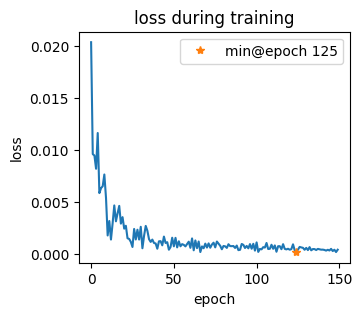

Epoch 0155 | Total Loss 0.011
Epoch 0160 | Total Loss 0.013
Epoch 0165 | Total Loss 0.007
Epoch 0170 | Total Loss 0.011
Epoch 0175 | Total Loss 0.006
Epoch 0180 | Total Loss 0.006
Epoch 0185 | Total Loss 0.010
Epoch 0190 | Total Loss 0.010
Epoch 0195 | Total Loss 0.005
Epoch 0200 | Total Loss 0.010


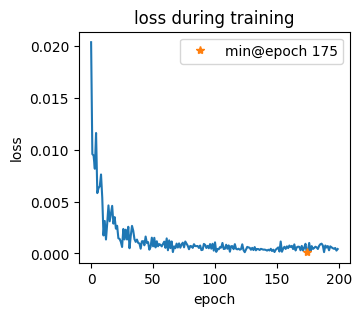

Epoch 0205 | Total Loss 0.008
Epoch 0210 | Total Loss 0.005
Epoch 0215 | Total Loss 0.006
Epoch 0220 | Total Loss 0.009
Epoch 0225 | Total Loss 0.005
Epoch 0230 | Total Loss 0.008
Epoch 0235 | Total Loss 0.010
Epoch 0240 | Total Loss 0.006
Epoch 0245 | Total Loss 0.016
Epoch 0250 | Total Loss 0.009


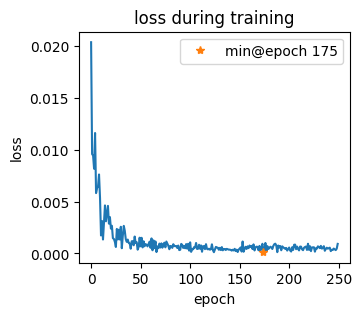

Epoch 0255 | Total Loss 0.018
Epoch 0260 | Total Loss 0.011
Epoch 0265 | Total Loss 0.016
Epoch 0270 | Total Loss 0.008
Epoch 0275 | Total Loss 0.008
Epoch 0280 | Total Loss 0.007
Epoch 0285 | Total Loss 0.005
Epoch 0290 | Total Loss 0.005
Epoch 0295 | Total Loss 0.005
Epoch 0300 | Total Loss 0.005


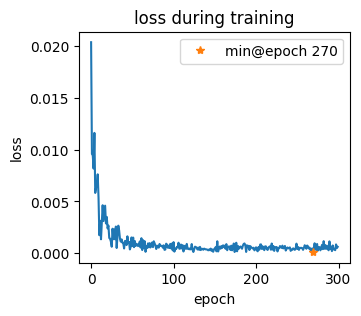

Epoch 0305 | Total Loss 0.006
Epoch 0310 | Total Loss 0.006
Epoch 0315 | Total Loss 0.018
Epoch 0320 | Total Loss 0.021
Epoch 0325 | Total Loss 0.013
Epoch 0330 | Total Loss 0.006
Epoch 0335 | Total Loss 0.004
Epoch 0340 | Total Loss 0.005
Epoch 0345 | Total Loss 0.006
Epoch 0350 | Total Loss 0.009


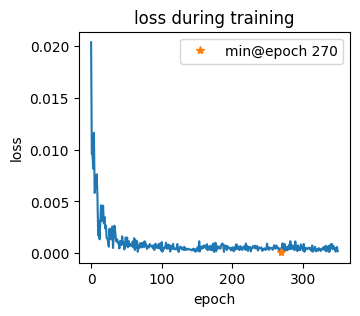

Epoch 0355 | Total Loss 0.008
Epoch 0360 | Total Loss 0.008
Epoch 0365 | Total Loss 0.004
Epoch 0370 | Total Loss 0.010
early stop


In [114]:
def visualize(true_y, pred_y, odefunc, itr, fig_path=None):
    if fig_path==None: fig_path = 'png'; makedirs(fig_path)
    fig, (ax_traj, ax_phase, ax_vecfield) = plt.subplots(1, 3, figsize=(12,4))

    ax_traj.cla()
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('t')
    ax_traj.set_ylabel('Aa, A')
    ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:,0,0],
                 t.cpu().numpy(), true_y.cpu().numpy()[:,0,1], 'g-')
    ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:,0,0], '--',
                 t.cpu().numpy(), pred_y.cpu().numpy()[:,0,1], 'b--')
    ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
    ax_traj.set_ylim(-0.1, Dose * 1.1) # Since Aa and A cannot exceed [0, Dose]
    ax_traj.legend(['True Aa', 'True A', 'Pred Aa', 'Pred A'])

    ax_phase.cla()
    ax_phase.set_title('Phase Portrait')
    ax_phase.set_xlabel('Aa')
    ax_phase.set_ylabel('A')
    ax_phase.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'g-')
    ax_phase.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'b--')
    ax_phase.set_xlim(-0.1, Dose*1.1) # since Aa cannot exceed [0, Dose]
    ax_phase.set_ylim(-0.1, Dose*1.1) # since A  cannot exceed [0, Dose]
    ax_phase.legend(['True', 'Pred'])

    ax_vecfield.cla()
    ax_vecfield.set_title('Learned Vector Field')
    ax_vecfield.set_xlabel('Aa')
    ax_vecfield.set_ylabel('A')

    y, x = np.mgrid[-2:2:21j, -2:2:21j]
    dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
    mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
    dydt = (dydt / mag)
    dydt = dydt.reshape(21, 21, 2)

    ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
    ax_vecfield.set_xlim(-2, 2)
    ax_vecfield.set_ylim(-2, 2)


    # plt.savefig('png/{:03d}'.format(itr))
    fig.suptitle('Iteration {:03d}'.format(itr))
    fig.tight_layout()
    fig.savefig('png/{:03d}'.format(itr))
    # plt.draw()
    # plt.pause(0.001)
    plt.close(fig)


ii = 0
func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
# end = time.time()
min_loss = np.inf
min_epoch = 0
loss_all = []
patience = 100
model_path_ = 'test.pt'

for epoch in range(1, niters+1):
    func.train()
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y-batch_y))
    loss_all.append(loss.item())
    loss.backward()
    optimizer.step()

    if loss.item() < min_loss: # loss drop, save model
        min_loss = loss.item(); min_epoch = epoch
        torch.save(func.state_dict(), model_path_)

    if epoch - min_epoch > patience:
        print('early stop'); break

    if epoch % test_freq == 0 and viz:
        func.eval()
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y-true_y))
            print('Epoch {:04d} | Total Loss {:.3f}'.format(epoch, loss.item()))
            visualize(true_y, pred_y, func, ii) # ii is the png figure pass num
            ii += 1

            # Visualize loss during training
            if ii % 10 == 0:
                plt.plot(loss_all)
                plt.plot(min_epoch-1, min_loss, '*',
                         label=f'min@epoch {min_epoch}')
                plt.xlabel('epoch'); plt.ylabel('loss');
                plt.title('loss during training')
                plt.legend(); plt.show(); plt.close()


In [115]:
import imageio
images = []
# for filename in filenames:
for i in range(ii):
    filename = '{:03d}.png'.format(i)
    filename = f'{fig_path}/{filename}'
    images.append(imageio.imread(filename))
# imageio.mimsave('png/gif.gif', images, fps=30)

<ipython-input-115-06ffbc3f5b11>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


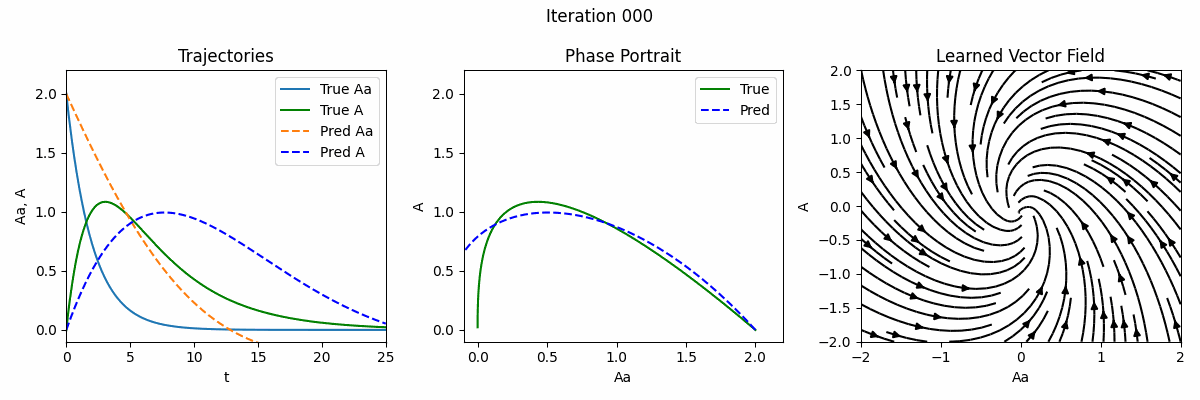

In [116]:
imageio.mimsave('png/gif.gif', images, fps=3)
from IPython.display import Image
Image('png/gif.gif')